_Developer Note:_ if you may make a PR in the future, be sure to copy this
notebook, and use the `gitignore` prefix `temp` to avoid future conflicts.

This is one notebook in a multi-part series on clusterless decoding in Spyglass 

- To set up your Spyglass environment and database, see
  [the Setup notebook](./00_Setup.ipynb)
- For additional info on DataJoint syntax, including table definitions and
  inserts, see
  [the Insert Data notebook](./01_Insert_Data.ipynb)
- Prior to running, please familiarize yourself with the [spike sorting
  pipeline](./02_Spike_Sorting.ipynb) and generate input position data with
  either the [Trodes](./20_Position_Trodes.ipynb) or DLC notebooks
  ([1](./21_Position_DLC_1.ipynb), [2](./22_Position_DLC_2.ipynb),
  [3](./23_Position_DLC_3.ipynb)).

The goal of this notebook is to populate the `UnitWaveformFeatures` table, which depends `SpikeSortingOutput`. This table contains the features of the waveforms of each unit.

While clusterless decoding avoids actual spike sorting, we need to pass through these tables to maintain (relative) pipeline simplicity. Pass-through tables keep spike sorting and clusterless waveform extraction as similar as possible, by using shared steps. Here, "spike sorting" involves simple thresholding (sorter: clusterless_thresholder).

Let's start with the following nwb file and time interval:

In [2]:
from pathlib import Path
import datajoint as dj

dj.config.load(
    Path("../dj_local_conf.json").absolute()
)  # load config for database connection info

nwb_copy_file_name = "mediumnwb20230802_.nwb"
interval_list_name = "pos 0 valid times"

If you haven't already, run the [Insert Data notebook](./01_Insert_Data.ipynb) to populate the tables.

These next steps are the same as in the [Spike Sorting notebook](./10_Spike_SortingV1.ipynb), but we'll repeat them here for clarity. These are pre-processing steps that are shared between spike sorting and clusterless decoding.

We first set the `SortGroup` to define which contacts are sorted together.

We then setup for spike sorting by bandpass filtering and whitening the data via the `SpikeSortingRecording` table.

In [3]:
import spyglass.spikesorting.v1 as sgs

sgs.SortGroup.set_group_by_shank(nwb_file_name=nwb_copy_file_name)

sort_group_ids = (sgs.SortGroup & {"nwb_file_name": nwb_copy_file_name}).fetch(
    "sort_group_id"
)

group_keys = []
for sort_group_id in sort_group_ids:
    key = {
        "nwb_file_name": nwb_copy_file_name,
        "sort_group_id": sort_group_id,
        "interval_list_name": interval_list_name,
        "preproc_param_name": "default",
        "team_name": "Alison Comrie",
    }
    group_keys.append(key)
    sgs.SpikeSortingRecordingSelection.insert_selection(key)

sgs.SpikeSortingRecording.populate(group_keys)

[2024-01-02 11:22:08,897][INFO]: Connecting root@localhost:3306
[2024-01-02 11:22:08,981][INFO]: Connected root@localhost:3306
[11:22:10][WARNING] Spyglass: Similar row(s) already inserted.
[11:22:10][WARNING] Spyglass: Similar row(s) already inserted.
[11:22:10][WARNING] Spyglass: Similar row(s) already inserted.
[11:22:10][WARNING] Spyglass: Similar row(s) already inserted.
[11:22:10][WARNING] Spyglass: Similar row(s) already inserted.
[11:22:10][WARNING] Spyglass: Similar row(s) already inserted.
[11:22:10][WARNING] Spyglass: Similar row(s) already inserted.
[11:22:10][WARNING] Spyglass: Similar row(s) already inserted.
[11:22:10][WARNING] Spyglass: Similar row(s) already inserted.
[11:22:10][WARNING] Spyglass: Similar row(s) already inserted.
[11:22:10][WARNING] Spyglass: Similar row(s) already inserted.
[11:22:10][WARNING] Spyglass: Similar row(s) already inserted.
[11:22:10][WARNING] Spyglass: Similar row(s) already inserted.
[11:22:10][WARNING] Spyglass: Similar row(s) already i

Next we do artifact detection. Here we skip it by setting the `artifact_param_name` to `None`, but in practice you should detect artifacts as it will affect the decoding.

In [4]:
recording_ids = (
    sgs.SpikeSortingRecordingSelection & {"nwb_file_name": nwb_copy_file_name}
).fetch("recording_id")

group_keys = []
for recording_id in recording_ids:
    key = {
        "recording_id": recording_id,
        "artifact_param_name": "none",
    }
    group_keys.append(key)
    sgs.ArtifactDetectionSelection.insert_selection(key)

sgs.ArtifactDetection.populate(group_keys)

[11:22:15][WARNING] Spyglass: Similar row(s) already inserted.
[11:22:15][WARNING] Spyglass: Similar row(s) already inserted.
[11:22:15][WARNING] Spyglass: Similar row(s) already inserted.
[11:22:15][WARNING] Spyglass: Similar row(s) already inserted.
[11:22:15][WARNING] Spyglass: Similar row(s) already inserted.
[11:22:15][WARNING] Spyglass: Similar row(s) already inserted.
[11:22:15][WARNING] Spyglass: Similar row(s) already inserted.
[11:22:15][WARNING] Spyglass: Similar row(s) already inserted.
[11:22:15][WARNING] Spyglass: Similar row(s) already inserted.
[11:22:15][WARNING] Spyglass: Similar row(s) already inserted.
[11:22:15][WARNING] Spyglass: Similar row(s) already inserted.
[11:22:15][WARNING] Spyglass: Similar row(s) already inserted.
[11:22:15][WARNING] Spyglass: Similar row(s) already inserted.
[11:22:15][WARNING] Spyglass: Similar row(s) already inserted.
[11:22:15][WARNING] Spyglass: Similar row(s) already inserted.
[11:22:15][WARNING] Spyglass: Similar row(s) already in

Now we run the "spike sorting", which in our case is simply thresholding the signal to find spikes. We use the `SpikeSorting` table to store the results. Note that `sorter_param_name` defines the parameters for thresholding the signal.

In [5]:
group_keys = []
for recording_id in recording_ids:
    key = {
        "recording_id": recording_id,
        "sorter": "clusterless_thresholder",
        "sorter_param_name": "default_clusterless",
        "nwb_file_name": nwb_copy_file_name,
        "interval_list_name": str(
            (
                sgs.ArtifactDetectionSelection & {"recording_id": recording_id}
            ).fetch1("artifact_id")
        ),
    }
    group_keys.append(key)
    sgs.SpikeSortingSelection.insert_selection(key)

sgs.SpikeSorting.populate(group_keys)

[11:22:17][INFO] Spyglass: Similar row(s) already inserted.
[11:22:17][INFO] Spyglass: Similar row(s) already inserted.
[11:22:17][INFO] Spyglass: Similar row(s) already inserted.
[11:22:17][INFO] Spyglass: Similar row(s) already inserted.
[11:22:17][INFO] Spyglass: Similar row(s) already inserted.
[11:22:17][INFO] Spyglass: Similar row(s) already inserted.
[11:22:17][INFO] Spyglass: Similar row(s) already inserted.
[11:22:17][INFO] Spyglass: Similar row(s) already inserted.
[11:22:17][INFO] Spyglass: Similar row(s) already inserted.
[11:22:17][INFO] Spyglass: Similar row(s) already inserted.
[11:22:17][INFO] Spyglass: Similar row(s) already inserted.
[11:22:17][INFO] Spyglass: Similar row(s) already inserted.
[11:22:17][INFO] Spyglass: Similar row(s) already inserted.
[11:22:17][INFO] Spyglass: Similar row(s) already inserted.
[11:22:17][INFO] Spyglass: Similar row(s) already inserted.
[11:22:17][INFO] Spyglass: Similar row(s) already inserted.
[11:22:17][INFO] Spyglass: Similar row(s

For clusterless decoding we do not need any manual curation, but for the sake of the pipeline, we need to store the output of the thresholding in the `CurationV1` table and insert this into the `SpikeSortingOutput` table.

In [6]:
from spyglass.spikesorting.merge import SpikeSortingOutput

sorting_ids = (
    sgs.SpikeSortingSelection & {"nwb_file_name": nwb_copy_file_name}
).fetch("sorting_id")

for sorting_id in sorting_ids:
    try:
        sgs.CurationV1.insert_curation(sorting_id=sorting_id)
    except KeyError as e:
        pass

SpikeSortingOutput.insert(
    sgs.CurationV1().fetch("KEY"),
    part_name="CurationV1",
    skip_duplicates=True,
)

Finally, we extract the waveform features of each SortGroup. This is done by the `UnitWaveformFeatures` table.

To set this up, we use the `WaveformFeaturesParams` to define the time around the spike that we want to use for feature extraction, and which features to extract. Here is an example of the parameters used for extraction the amplitude of the negative peak of the waveform:
```python

waveform_extraction_params = {
    "ms_before": 0.5,
    "ms_after": 0.5,
    "max_spikes_per_unit": None,
    "n_jobs": 5,
    "total_memory": "5G",
}
waveform_feature_params = {
    "amplitude": {
        "peak_sign": "neg",
        "estimate_peak_time": False,
    }
}
```

We see that we want 0.5 ms of time before and after the peak of the negative spike. We also see that we want to extract the amplitude of the negative peak, and that we do not want to estimate the peak time (since we know it is at 0 ms).


You can define other features to extract such as spatial location of the spike:
```python
waveform_extraction_params = {
    "ms_before": 0.5,
    "ms_after": 0.5,
    "max_spikes_per_unit": None,
    "n_jobs": 5,
    "total_memory": "5G",
}
waveform_feature_params = {
    "amplitude": {
        "peak_sign": "neg",
        "estimate_peak_time": False,
    },
    "spike location": {}
}

```


In [7]:
from spyglass.decoding.v1.waveform_features import WaveformFeaturesParams

waveform_extraction_params = {
    "ms_before": 0.5,
    "ms_after": 0.5,
    "max_spikes_per_unit": None,
    "n_jobs": 5,
    "total_memory": "5G",
}
waveform_feature_params = {
    "amplitude": {
        "peak_sign": "neg",
        "estimate_peak_time": False,
    }
}

WaveformFeaturesParams.insert1(
    {
        "features_param_name": "amplitude",
        "params": {
            "waveform_extraction_params": waveform_extraction_params,
            "waveform_feature_params": waveform_feature_params,
        },
    },
    skip_duplicates=True,
)

WaveformFeaturesParams()

features_param_name a name for this set of parameters,params the parameters for the waveform features
amplitude,=BLOB=
"amplitude, spike_location",=BLOB=


Now that we've inserted the waveform features parameters, we need to define which parameters to use for each SortGroup. This is done by the `UnitWaveformFeaturesSelection` table. We need to link the primary key `merge_id` from the `SpikeSortingOutput` table to a features parameter set.

In [8]:
from spyglass.decoding.v1.waveform_features import UnitWaveformFeaturesSelection

UnitWaveformFeaturesSelection()

spikesorting_merge_id,features_param_name a name for this set of parameters


First we find the units we need:

In [9]:
from spyglass.spikesorting.merge import SpikeSortingOutput

merge_ids = (
    (SpikeSortingOutput.CurationV1 * sgs.SpikeSortingSelection)
    & {
        "nwb_file_name": nwb_copy_file_name,
        "sorter": "clusterless_thresholder",
        "sorter_param_name": "default_clusterless",
    }
).fetch("merge_id")
merge_ids

array([UUID('86acdb0f-84f0-73a2-a851-1f8305cd2e41'),
       UUID('46829e10-1984-99a1-65a3-2b485a2f037f'),
       UUID('ec308784-2bfb-dd90-147c-e4d44e5f649b'),
       UUID('4b3065e5-76c2-bd48-32a1-ae62484f9314'),
       UUID('609aeb54-dc2e-52d3-91bf-1728e0a2cf09'),
       UUID('88492b1c-f4a9-9669-bb5b-7f1573015187'),
       UUID('f515c07f-fc80-b28a-750d-d0d5491259f4'),
       UUID('f4e29a80-ec96-dbe8-7081-425ac311b74c'),
       UUID('d7754d5f-af01-19f4-3fdc-c9635081667a'),
       UUID('2567bf67-bc67-47a5-aa2a-2bce19da232d'),
       UUID('d65a1bf3-797d-b01f-e8be-2cea90b14c20'),
       UUID('92c336ee-81f4-0af9-4f60-9bc32e71bc9f'),
       UUID('aa8bc575-0715-69e9-5da7-313a0e1ee769'),
       UUID('26310ce7-9ac3-4159-99f8-a3ad17037235'),
       UUID('7355bdf3-f31c-4c22-1a09-50d9f6f5f037'),
       UUID('189fb8c6-f964-00a9-f392-a9dbb138ea63'),
       UUID('c4f24219-c023-8783-df53-2bbc88c9ad9c'),
       UUID('411dff13-44f0-3e03-e867-689ae275e418'),
       UUID('153954b2-b230-cb1f-749d-f977a22ea

Then we link them with the features parameters:

In [10]:
selection_keys = [
    {
        "spikesorting_merge_id": merge_id,
        "features_param_name": "amplitude",
    }
    for merge_id in merge_ids
]
UnitWaveformFeaturesSelection.insert(selection_keys, skip_duplicates=True)

UnitWaveformFeaturesSelection & selection_keys

spikesorting_merge_id,features_param_name a name for this set of parameters
00763b68-d663-c446-0555-1f2622d7da50,amplitude
03954edd-f8fd-3dd9-cd10-f0eee47d6b3d,amplitude
0720e5f2-625e-09d2-b522-ca2652c09f2a,amplitude
153954b2-b230-cb1f-749d-f977a22eaae9,amplitude
189fb8c6-f964-00a9-f392-a9dbb138ea63,amplitude
2567bf67-bc67-47a5-aa2a-2bce19da232d,amplitude
26310ce7-9ac3-4159-99f8-a3ad17037235,amplitude
411dff13-44f0-3e03-e867-689ae275e418,amplitude
43a98eab-1fa6-184b-1f09-2e923984b03a,amplitude
46829e10-1984-99a1-65a3-2b485a2f037f,amplitude


Finally, we extract the waveform features, by populating the `UnitWaveformFeatures` table:

In [11]:
from spyglass.decoding.v1.waveform_features import UnitWaveformFeatures

UnitWaveformFeatures.populate(selection_keys)

/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/spikeinterface/core/waveform_extractor.py:275: UserWarning: Sorting object is not dumpable, which might result in downstream errors for parallel processing. To make the sorting dumpable, use the `sorting.save()` function.
  warn(


extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-02 11:23:00,301][WARNING]: Skipped checksum for file with hash: b12a9d1d-d019-7c0e-09bf-355936d14915, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_DRQ7MITSST.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[11:23:00][INFO] Spyglass: Writing new NWB file mediumnwb20230802_OX2ORY4MKR.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-02 11:23:09,887][WARNING]: Skipped checksum for file with hash: c8f4786b-9ef7-61f7-cae0-251e84c59317, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_XXD817HX5I.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[11:23:10][INFO] Spyglass: Writing new NWB file mediumnwb20230802_O1OGMFS4AF.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-02 11:23:19,778][WARNING]: Skipped checksum for file with hash: 6907761c-fb37-6528-56d7-507d5525a69b, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_JN3OG7ZA5E.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[11:23:20][INFO] Spyglass: Writing new NWB file mediumnwb20230802_Y3E5VJAR0Z.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-02 11:23:29,678][WARNING]: Skipped checksum for file with hash: 1767224a-ebf4-819e-deb3-67c6d47bcf57, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_BKRH5CPBEZ.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[11:23:29][INFO] Spyglass: Writing new NWB file mediumnwb20230802_E66YNNI7S4.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-02 11:23:40,093][WARNING]: Skipped checksum for file with hash: 45bce4f3-1861-a3bb-a7d1-522a39d83dde, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_RX8QUCHGVT.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[11:23:40][INFO] Spyglass: Writing new NWB file mediumnwb20230802_UZ3IGTO5AU.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-02 11:23:50,600][WARNING]: Skipped checksum for file with hash: 36da4c85-d069-0e7f-3086-94efb47e6b78, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_VHA7WLA4XX.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[11:23:50][INFO] Spyglass: Writing new NWB file mediumnwb20230802_CHBHDNP2W8.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-02 11:24:00,723][WARNING]: Skipped checksum for file with hash: 0972a7a6-1e32-5164-7fcc-e2b9aff76c05, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_9SQUOJRQSS.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[11:24:01][INFO] Spyglass: Writing new NWB file mediumnwb20230802_L0LVGC1DFT.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-02 11:24:10,661][WARNING]: Skipped checksum for file with hash: 7133aab2-7288-85f8-f65f-695afa564e63, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_4LOGBKOP0I.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[11:24:10][INFO] Spyglass: Writing new NWB file mediumnwb20230802_428JKP43Q1.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-02 11:24:20,521][WARNING]: Skipped checksum for file with hash: 1ea4fc37-411c-0da6-00ec-f18beaa69e06, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_C8VMYH7C9V.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[11:24:20][INFO] Spyglass: Writing new NWB file mediumnwb20230802_X13I3BGUB1.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-02 11:24:30,164][WARNING]: Skipped checksum for file with hash: 7cd08c29-050b-30d6-93a4-6ede72933662, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_OQL3ITCETP.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[11:24:30][INFO] Spyglass: Writing new NWB file mediumnwb20230802_0LXKB5BPTL.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-02 11:24:40,329][WARNING]: Skipped checksum for file with hash: a2e79fe8-35f0-0f60-a4a5-27eb822c57d5, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_GU6KPWJ35V.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[11:24:40][INFO] Spyglass: Writing new NWB file mediumnwb20230802_HX2DNMBYI5.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-02 11:24:49,788][WARNING]: Skipped checksum for file with hash: 386e6724-08dc-8cca-6670-f8ed557cdd44, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_H8R2XMWTYU.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[11:24:50][INFO] Spyglass: Writing new NWB file mediumnwb20230802_9BC3PGE9BE.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-02 11:24:58,435][WARNING]: Skipped checksum for file with hash: 41849951-22a3-e057-5b72-398a5fd795fb, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_KKBMX8E512.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[11:24:58][INFO] Spyglass: Writing new NWB file mediumnwb20230802_L35KWBBILV.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-02 11:25:07,943][WARNING]: Skipped checksum for file with hash: ff8fb4a0-6100-1d83-7568-5ee8e49be5d3, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_4VRPO41KQE.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[11:25:08][INFO] Spyglass: Writing new NWB file mediumnwb20230802_BSIV3DLAMV.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-02 11:25:17,690][WARNING]: Skipped checksum for file with hash: 7019ae20-b254-003d-969c-27238030f925, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_HLUMWXS9R0.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[11:25:17][INFO] Spyglass: Writing new NWB file mediumnwb20230802_PWCOH5ROGU.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-02 11:25:27,785][WARNING]: Skipped checksum for file with hash: 6ede8753-2030-2522-3d8e-1c88ccda72d3, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_AGDX79CGKU.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[11:25:28][INFO] Spyglass: Writing new NWB file mediumnwb20230802_JE0YCFOTU6.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-02 11:25:37,853][WARNING]: Skipped checksum for file with hash: adf6cda7-1231-8218-2a7d-d0ea495ac5e0, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_QW819UWMPS.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[11:25:38][INFO] Spyglass: Writing new NWB file mediumnwb20230802_KFVKOTUGBY.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-02 11:25:46,039][WARNING]: Skipped checksum for file with hash: 9158e229-f0be-fe25-e5ac-c203bf9dd774, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_X1ENKGF5F6.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[11:25:46][INFO] Spyglass: Writing new NWB file mediumnwb20230802_6ZW1JK07GZ.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-02 11:25:55,892][WARNING]: Skipped checksum for file with hash: 07fae3c3-9816-a718-b099-3c85adb7cb53, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_ND0D5I9STR.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[11:25:56][INFO] Spyglass: Writing new NWB file mediumnwb20230802_7J5JW85MUW.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-02 11:26:06,531][WARNING]: Skipped checksum for file with hash: f3da67cc-99de-dde7-2b4e-86a8d1b9df6d, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_MYA6F5PO4T.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[11:26:06][INFO] Spyglass: Writing new NWB file mediumnwb20230802_P9LLTXF2UV.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-02 11:26:16,350][WARNING]: Skipped checksum for file with hash: 5e927005-d667-e8e2-0cf8-d4250263085e, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_2GYJ9DZDZM.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[11:26:16][INFO] Spyglass: Writing new NWB file mediumnwb20230802_P1S52EP8IG.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-02 11:26:26,229][WARNING]: Skipped checksum for file with hash: 47d51f63-e94f-52f7-e633-a2f30d9a889f, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_VUCHU58MU8.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[11:26:26][INFO] Spyglass: Writing new NWB file mediumnwb20230802_L98HKJBI6P.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-02 11:26:36,556][WARNING]: Skipped checksum for file with hash: 43eefbae-67f4-1fbc-ac02-e37029006ed9, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_B36EKV3244.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[11:26:36][INFO] Spyglass: Writing new NWB file mediumnwb20230802_CHGNLEZ92L.nwb


In [12]:
UnitWaveformFeatures & selection_keys

spikesorting_merge_id,features_param_name a name for this set of parameters,analysis_file_name name of the file,object_id the NWB object that stores the waveforms
00763b68-d663-c446-0555-1f2622d7da50,amplitude,mediumnwb20230802_OX2ORY4MKR.nwb,db7b7b7c-a97b-4982-96d9-60dd41d0546d
03954edd-f8fd-3dd9-cd10-f0eee47d6b3d,amplitude,mediumnwb20230802_O1OGMFS4AF.nwb,cbdbc6ab-aeb4-4447-8d26-6bfb56a44081
0720e5f2-625e-09d2-b522-ca2652c09f2a,amplitude,mediumnwb20230802_Y3E5VJAR0Z.nwb,e36c31d6-2ebf-46eb-b7fe-028e88945e3a
153954b2-b230-cb1f-749d-f977a22eaae9,amplitude,mediumnwb20230802_E66YNNI7S4.nwb,4768d18a-ab94-4ba8-87fa-9a11f2d8d5cc
189fb8c6-f964-00a9-f392-a9dbb138ea63,amplitude,mediumnwb20230802_UZ3IGTO5AU.nwb,d4ba1164-a043-46b3-924b-a2fc999f46d3
2567bf67-bc67-47a5-aa2a-2bce19da232d,amplitude,mediumnwb20230802_CHBHDNP2W8.nwb,d7832810-313b-4186-861a-7e11341553d6
26310ce7-9ac3-4159-99f8-a3ad17037235,amplitude,mediumnwb20230802_L0LVGC1DFT.nwb,202d6dae-c1b4-4915-850a-2f2f8f05d159
411dff13-44f0-3e03-e867-689ae275e418,amplitude,mediumnwb20230802_428JKP43Q1.nwb,15dc2df6-26c7-415d-9446-aa44ecc40af1
43a98eab-1fa6-184b-1f09-2e923984b03a,amplitude,mediumnwb20230802_X13I3BGUB1.nwb,5ad143d4-235f-4ad9-aa94-f7140bc71853
46829e10-1984-99a1-65a3-2b485a2f037f,amplitude,mediumnwb20230802_0LXKB5BPTL.nwb,554ed58c-28c1-4786-850f-2be0a557574a


Now that we've extracted the data, we can inspect the results. Let's fetch the data:

In [14]:
spike_times, spike_waveform_features = (
    UnitWaveformFeatures & selection_keys
).fetch_data()

[2024-01-02 11:27:25,269][WARNING]: Skipped checksum for file with hash: 300bbca3-e3e5-b477-cad5-2d2fb4d790cd, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_OX2ORY4MKR.nwb
[2024-01-02 11:27:25,272][WARNING]: Skipped checksum for file with hash: eba88548-8666-4c8a-6142-de9a8c439d8e, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_O1OGMFS4AF.nwb
[2024-01-02 11:27:25,274][WARNING]: Skipped checksum for file with hash: 4e8d390c-bbe4-714e-b050-8c9551de4644, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_Y3E5VJAR0Z.nwb


[2024-01-02 11:27:25,276][WARNING]: Skipped checksum for file with hash: ba6297db-6420-4727-d704-d852c44e8a41, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_E66YNNI7S4.nwb
[2024-01-02 11:27:25,279][WARNING]: Skipped checksum for file with hash: f128807d-04ef-323f-0f88-1d269e73b75a, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_UZ3IGTO5AU.nwb
[2024-01-02 11:27:25,281][WARNING]: Skipped checksum for file with hash: fbba2646-b978-3a2b-8feb-c5af5e7efc19, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_CHBHDNP2W8.nwb
[2024-01-02 11:27:25,283][WARNING]: Skipped checksum for file with hash: e156635c-e762-2aff-4ea4-30f4088c51ff, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_L0LVGC1DFT.nwb
[2024-01-02 11:27:25,286][WARNING]: Skipped checksum for file with hash: 19e855c8-b423-fc02-7832-baf

Let's look at the features shape. This is a list corresponding to tetrodes, with each element being a numpy array of shape (n_spikes, n_features). The features in this case are the amplitude of each tetrode wire at the negative peak of the waveform.

In [15]:
for features in spike_waveform_features:
    print(features.shape)

(18, 4)
(44284, 4)
(43804, 4)
(57394, 4)
(36687, 4)
(41622, 4)
(4198, 4)
(21024, 4)
(21675, 4)
(39886, 4)
(6348, 4)
(12188, 4)
(2654, 4)
(51330, 4)
(8283, 4)
(106549, 4)
(76353, 4)
(803, 4)
(11367, 4)
(8952, 4)
(30772, 4)
(49808, 4)
(99400, 4)


We can plot the amplitudes to see if there is anything that looks neural and to look for outliers:

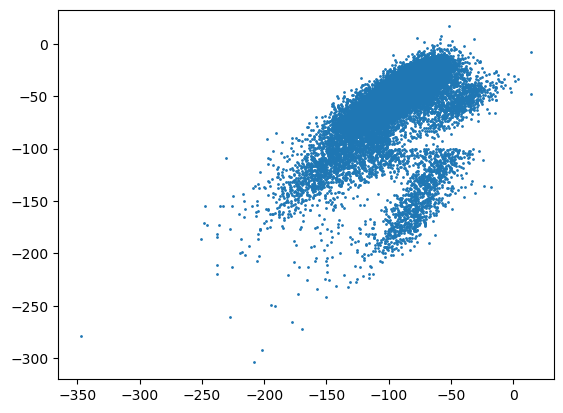

In [16]:
import matplotlib.pyplot as plt

tetrode_ind = 1
plt.scatter(
    spike_waveform_features[tetrode_ind][:, 0],
    spike_waveform_features[tetrode_ind][:, 1],
    s=1,
)